In [1]:
import itertools
import sys,os
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.2, rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [4]:
import mdtraj as md

In [5]:
def unit_normal_vector(v1, v2):
    """Calculates the unit normal vector to a plane defined by two vectors.

    Args:
        v1: The first vector defining the plane.
        v2: The second vector defining the plane.

    Returns:
        The unit normal vector to the plane.
    """

    normal = np.cross(v1, v2, axisa=1)
    norm = np.linalg.norm(normal, axis=1).reshape(np.shape(normal)[0],1)
    normal = normal / norm
    return normal

# GSY

In [15]:
xtc = "../data/soup_XXL_amber99sb-star-ildnTRUE_tip3p_dense_npt_proc.xtc"
gro = "../data/soup_XXL_amber99sb-star-ildnTRUE_tip3p_dense_npt_berendsen.gro"
traj = md.load_xtc(xtc, top=gro, stride=20)

In [16]:
traj.time[-1]

1000000.0

In [17]:
traj.n_frames

501

In [18]:
GLY = [x.index for x in list(traj.topology.residues) \
       if (x.name=='GLY')] 
SER = [x.index for x in list(traj.topology.residues) \
       if (x.name=='SER')] 
TYR = [x.index for x in list(traj.topology.residues) \
       if (x.name=='TYR')]

nres = np.array([len(GLY), len(SER), len(TYR)])

## Contacts

In [19]:
ib = 100
# Find contacts for residue pairs 
# 0: Gly; 1: Ser; 2: Tyr
contact_map = {}
contact_map[0] = {}; contact_map[1] = {}; contact_map[2] = {}

contact_map[0][0] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.combinations(GLY, 2)))    
contact_map[1][1] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.combinations(SER, 2)))
contact_map[2][2] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.combinations(TYR, 2)))
    
contact_map[0][1] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.product(GLY, SER)))
contact_map[0][2] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.product(GLY, TYR)))
contact_map[1][2] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.product(SER, TYR)))

In [20]:
rcut = 0.6

# Calculate number contacts for residue pairs 
n_cont = np.zeros((3,3), dtype=np.int64)
for k in contact_map.keys():
    for l in contact_map[k].keys():
            for m, (i,j) in enumerate(contact_map[k][l][1]):   
                n_cont[k,l] += sum(contact_map[k][l][0][:,m] < rcut)
            if (l != k):
                n_cont[l,k] = n_cont[k,l]
lsim = len(traj[ib:]) # normalize by simulation length
n_contacts = np.int64(n_cont/lsim)

# Calculate normalized number contacts for residue pairs 
n_contacts_norm = np.sum(n_cont, axis=0)/nres/lsim

# Calculate fraction of contacts for residue pairs
# Divides number of contacts by number of pairs for each specific type
f_contacts = np.zeros((3,3), dtype=np.float64)
for k in contact_map.keys():
    for l in contact_map[k].keys():
        f_contacts[k,l] = n_cont[k,l]/(len(contact_map[k][l][1]))
        if (l != k):
            f_contacts[l,k] = f_contacts[k,l]
f_contacts = f_contacts/lsim
f_contacts_norm = np.sum(f_contacts, axis=0, dtype=np.float64)

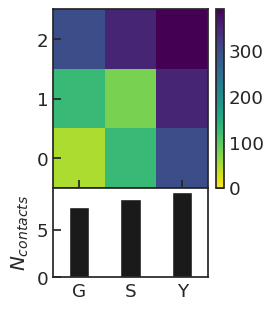

In [21]:
fig = plt.figure(figsize=(3.75,4))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,0.5])
ax0 = plt.subplot(gs[0,1])

im = ax0.imshow(n_contacts, cmap='viridis_r', \
                    vmin=0, aspect='auto', origin='lower')
divider = make_axes_locatable(ax0)
ax1 = divider.append_axes("bottom", size="50%", pad=0)
cax = divider.append_axes("right", size="5%", pad=0.08)
cb = plt.colorbar( im, ax=ax0, cax=cax )

ax1.set_xlim(-0.5, 2.5); 
ax1.set_xticks(range(3)); ax0.set_yticks(range(3))
ax1.set_xticklabels(['G', 'S', 'Y'])
    
ax1.bar(range(3), n_contacts_norm, color='k', width=0.4) 
ax1.set_ylabel('$N_{contacts}$')
plt.tight_layout()
#plt.savefig("figures/contacts_gsy.png", dpi=300, transparent=True)

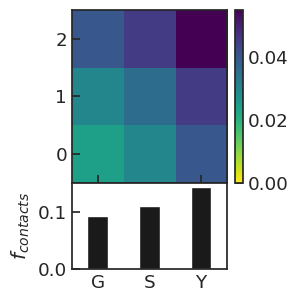

In [24]:
fig = plt.figure(figsize=(4,3.9))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,0.5])
ax0 = plt.subplot(gs[0,1])

im = ax0.imshow(f_contacts, cmap='viridis_r', \
                    vmin=0, vmax=0.055, aspect='auto', origin='lower')
divider = make_axes_locatable(ax0)
ax1 = divider.append_axes("bottom", size="50%", pad=0)
cax = divider.append_axes("right", size="5%", pad=0.08)
cb = plt.colorbar( im, ax=ax0, cax=cax )

ax1.set_xlim(-0.5, 2.5); 
ax1.set_xticks(range(3)); ax0.set_yticks(range(3))
ax1.set_xticklabels(['G', 'S', 'Y'])
    
ax1.bar(range(3), f_contacts_norm, color='k', width=0.4) 
ax1.set_ylabel('$f_{contacts}$')
plt.tight_layout()
#plt.savefig("figures/contacts_gsy_norm.png", dpi=300, transparent=True)

## $\pi$-stacking

In [25]:
# Get indexes for the first three atoms in the ring
CG = [x.index for x in list(traj.topology.atoms) \
       if (x.name=='CG' and x.residue.name =='TYR')]
CD1 = [x.index for x in list(traj.topology.atoms) \
       if (x.name=='CD1' and x.residue.name =='TYR')]
CD2 = [x.index for x in list(traj.topology.atoms) \
       if (x.name=='CD2' and x.residue.name =='TYR')]

In [26]:
# Get vectors normal to the plane
normal = []
for i,j,k in list(zip(CG,CD1,CD2)):
    # calculate bond vectors
    displacements = md.compute_displacements(traj, [[i,j], [i,k]])

    # calculate normal vectors
    normal.append(unit_normal_vector(displacements[:,0,:], displacements[:,1,:]))

In [27]:
#  Get angle between vectors
angle_between_planes = []
for i,j in itertools.combinations(range(len(TYR)),2):
    angle_between_planes.append(np.arccos((normal[i]*normal[j]).sum(1)))

In [29]:
ring_dist = []
for i,j in itertools.combinations(TYR,2):
    #print (list(traj.topology.residue(i).atoms))
    i_index =  [x.index for x in traj.topology.residue(i).atoms if
           x.name in ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']] 
    j_index =  [x.index for x in traj.topology.residue(j).atoms if
           x.name in ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']]
    ring_dist.append(np.mean(md.compute_distances(traj, list(itertools.product(i_index, j_index))), axis=1))

In [30]:
stacked = []
for i,pair in enumerate(list(itertools.combinations(TYR,2))):
    sel = np.logical_and(ring_dist[i] < 0.45, \
                        np.abs(angle_between_planes[i] - np.pi/2) > 1)
    if np.any(sel):
       atom_select = list([atom.index for atom in traj.top.residue(pair[0]).atoms]) + \
           list([atom.index for atom in traj.top.residue(pair[1]).atoms])
  #     #print (atom_select)
       stacked.append(traj[sel].atom_slice(atom_select))
stacked_all = md.join(stacked)
stacked_all.center_coordinates()
#stacked_all.save("gsy_pistacked.gro")

<mdtraj.Trajectory with 408 frames, 42 atoms, 2 residues, and unitcells at 0x715942f33a10>

In [ ]:
stacked = []
for i,pair in enumerate(list(itertools.combinations(TYR,2))):
    sel = np.logical_and(ring_dist[i] < 0.45, \
                        np.abs(angle_between_planes[i] - np.pi/2) > 1)
    if np.any(sel):
       atom_select = list([atom.index for atom in traj.top.residue(pair[0]).atoms]) + \
           list([atom.index for atom in traj.top.residue(pair[1]).atoms])
  #     #print (atom_select)
       stacked.append(traj[sel].atom_slice(atom_select))
stacked_all = md.join(stacked)
stacked_all.center_coordinates()
#stacked_all.save("gsy_pistacked.gro")

<mdtraj.Trajectory with 408 frames, 42 atoms, 2 residues, and unitcells at 0x7c65b7184d70>

In [ ]:
sel = np.array(ring_dist) < 0.65

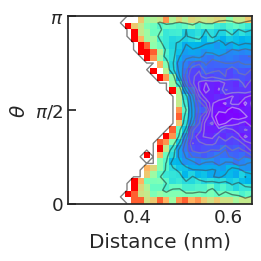

In [ ]:
fig, ax = plt.subplots(figsize=(2.85, 2.85))
nbins=30
counts, xbins, ybins, image = ax.hist2d(np.array(ring_dist)[sel], np.array(angle_between_planes)[sel], \
                                        bins=(np.linspace(0.25, 0.65, nbins), np.linspace(0, np.pi, nbins)), \
                                        norm=LogNorm(), cmap='rainbow_r')
ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
           linewidths=1, cmap='binary_r', alpha=0.5)

ax.set_yticks(np.linspace(0,np.pi,3)); ax.set_yticklabels([0, r"$\pi/2$", r"$\pi$"])        
ax.set_xlabel('Distance (nm)')
ax.set_ylabel(r'$\theta$')
plt.tight_layout()
#plt.savefig("figures/gsy_pipi_dist.png", dpi=300, transparent=True)

### sp<sub>2</sub>-$\pi$

In [93]:
table, bonds = traj.topology.to_dataframe()
print (table.head())

   serial name element  resSeq resName  chainID segmentID
0       1  CH3       C       1     ACE        0          
1       2   H1       H       1     ACE        0          
2       3   H2       H       1     ACE        0          
3       4   H3       H       1     ACE        0          
4       5    C       C       1     ACE        0          


In [94]:
# Find atoms from carboxyl groups in peptide bonds
C = [x.index for x in list(traj.topology.atoms) \
       if (x.name=='C' and x.residue.name in ['GLY', 'SER', 'TYR'])]
O = [x.index for x in list(traj.topology.atoms) \
       if (x.name=='O' and x.residue.name in ['GLY', 'SER', 'TYR'])]
N = [traj.topology.atom(i+1).index for i in O]
    #[x.index for x in list(traj.topology.atoms) \
#       if (x.name=='CA' and x.residue.name in ['GLY', 'SER', 'TYR'])]

back = list(zip(C,O,N))
n_back = len(back)

In [95]:
bb_ring_dist = []
for i,j in itertools.product(range(n_back), range(nres[2])):
    i_index = back[i]
    j_index =  [x.index for x in traj.topology.residue(TYR[j]).atoms if
           x.name in ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']]
    bb_ring_dist.append(np.median(md.compute_distances(traj, list(itertools.product(i_index, j_index))), axis=1))

In [96]:
# Get vectors normal to the bond plane
bond = []
for i,j,k in back:
    # calculate bond vectors
    displacements = md.compute_displacements(traj, [[i,j], [i,k]])
    # calculate normal vectors
    bond.append(unit_normal_vector(displacements[:,0,:], displacements[:,1,:]))

In [97]:
#  Get angle between vectors
angle_bond_ring = []
for i,j in itertools.product(range(n_back), range(nres[2])):
    angle_bond_ring.append(np.arccos((bond[i]*normal[j]).sum(1)))

ValueError: operands could not be broadcast together with shapes (51,3) (251,3) 

In [ ]:
sel = np.array(bb_ring_dist) < 0.65

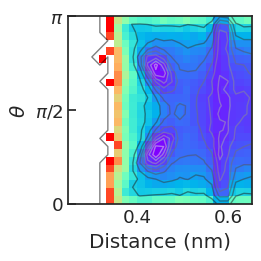

In [ ]:
fig, ax = plt.subplots(figsize=(2.85, 2.85))
nbins=25
counts, xbins, ybins, image = ax.hist2d(np.array(bb_ring_dist)[sel], np.array(angle_bond_ring)[sel], \
                                        bins=(np.linspace(0.25,0.65,nbins), np.linspace(0,np.pi,nbins)), \
                                        norm=LogNorm(), cmap='rainbow_r')
ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
           linewidths=1, cmap='binary_r', alpha=0.5)
#ax.axhline(3*np.pi/5, ls='--', color='k')
#ax.axhline(4*np.pi/5, ls='--', color='k')
ax.set_xlabel('Distance (nm)')
ax.set_ylabel(r'$\theta$')
ax.set_yticks(np.linspace(0,np.pi,3)); ax.set_yticklabels([0, r"$\pi/2$", r"$\pi$"])        
plt.tight_layout()
#plt.savefig("figures/gsy_sp2pi_dist.png", dpi=300, transparent=True)

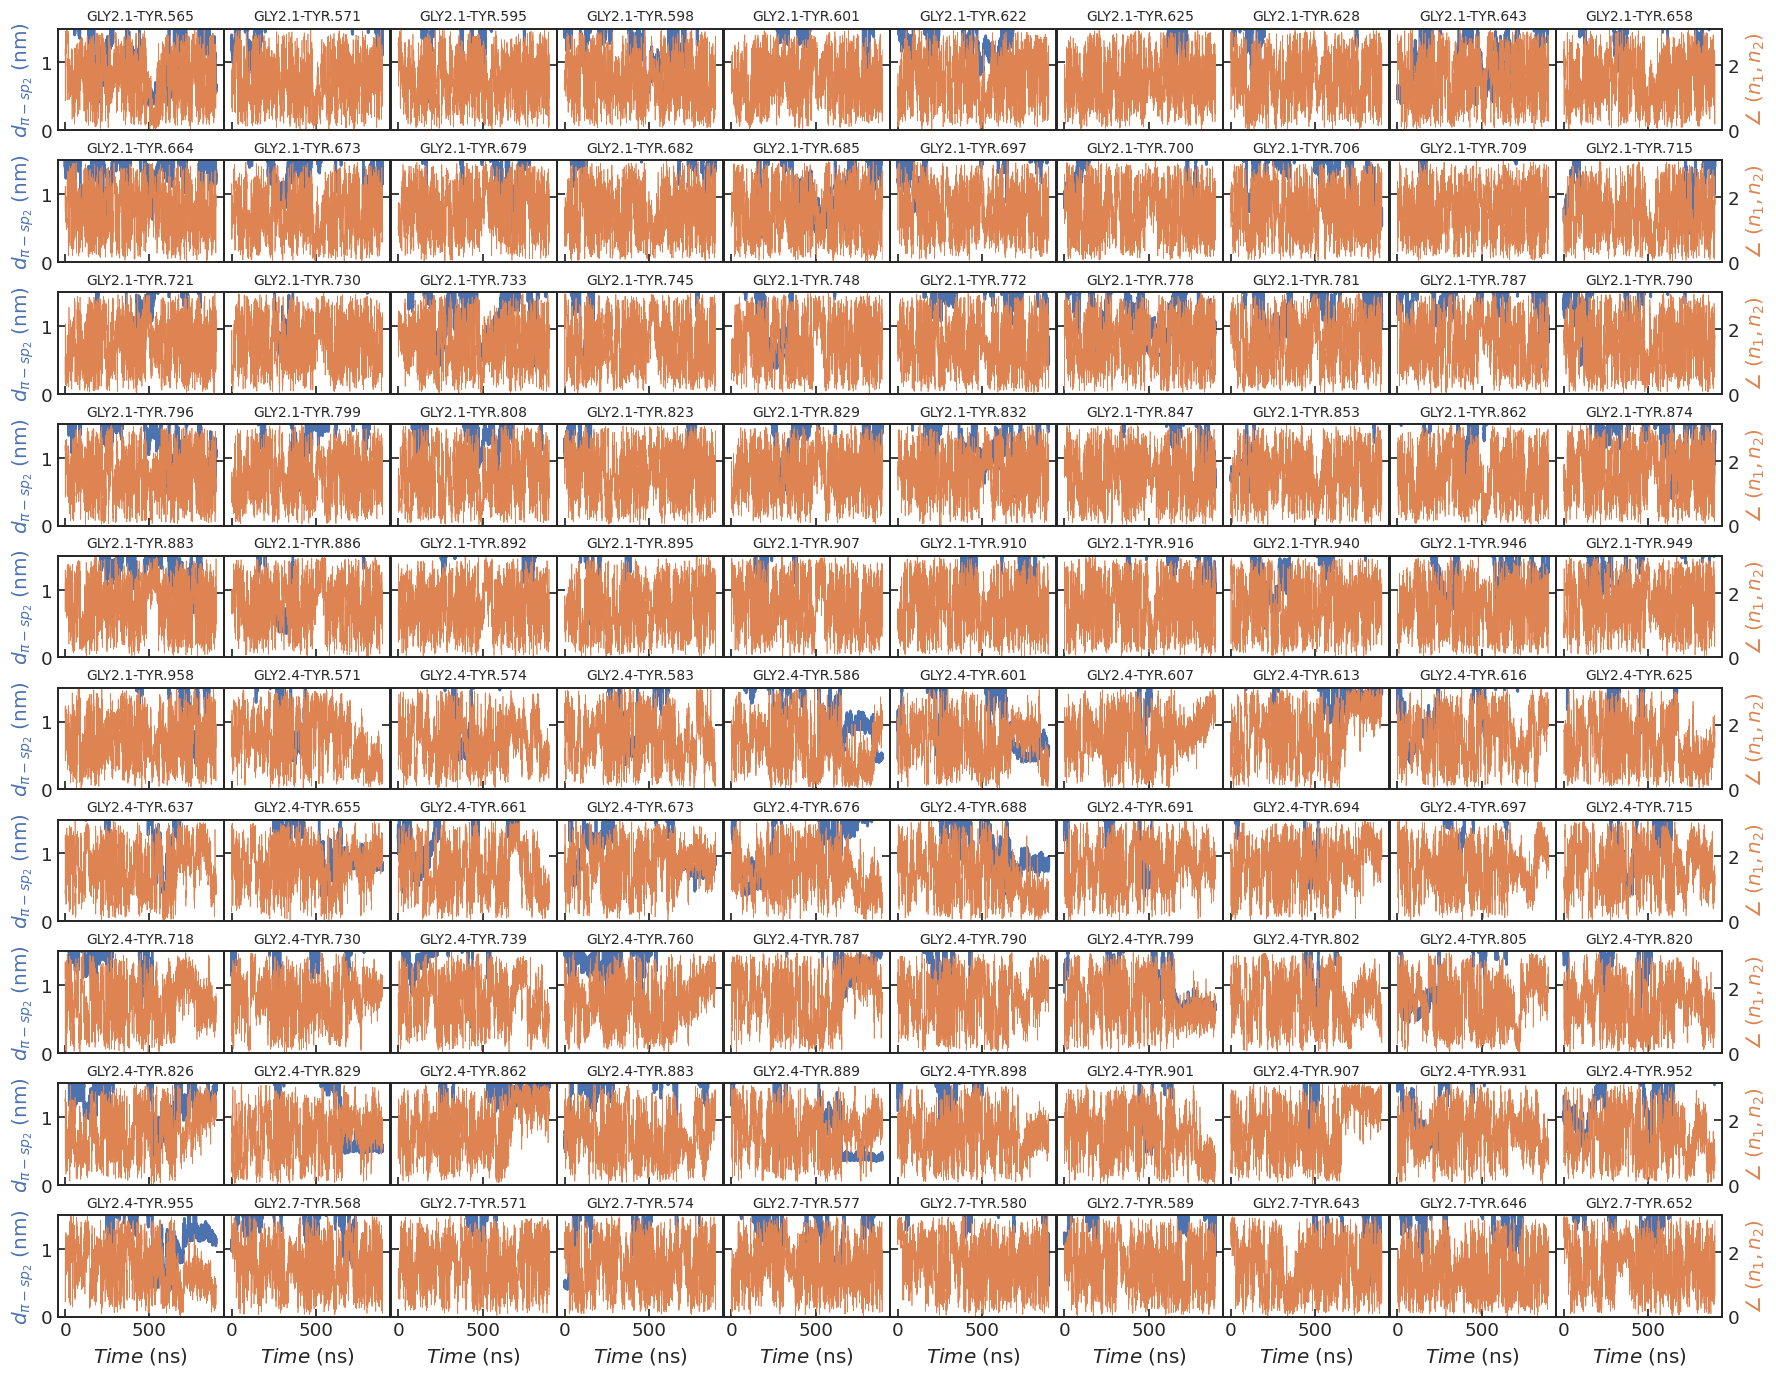

In [ ]:
combinations = list(itertools.product(range(n_back), range(nres[2])))
count = 0

sel = np.array(bb_ring_dist) < 0.5

fig, ax = plt.subplots(10,10,figsize=(18,14), sharex=True, sharey=True)
ax = ax.flatten()
for i,s in enumerate(sel):
    if np.any(s):
        k,l = combinations[i]
        label = "%s.%i-TYR.%i"%(str(traj.topology.atom(back[k][0]).residue),traj.topology.atom(back[k][0]).residue.index, TYR[l])

        ax[count].plot(traj.time*1e-3, bb_ring_dist[i], lw=2)

        axt = ax[count].twinx()
        axt.plot(traj.time*1e-3, angle_bond_ring[i], c='C1', lw=0.5)
        axt.set_ylim(0, np.pi)
        ax[count].set_title(label, fontsize=10)

        count +=1
        if (count)%10 == 0:
            axt.set_ylabel(r'$\angle$ ($n_1,n_2$)', color='C1')
        else:
            axt.set_yticklabels([])

        if count == 100:
            break    


[ax[i*10].set_ylabel(r'$d_{\pi-sp_2}$ (nm)', color='C0') for i in range(10)]
[ax[-i-1].set_xlabel(r'$Time$ (ns)') for i in range(10)]
ax[-1].set_ylim(0,1.5)
plt.tight_layout(w_pad=0, h_pad=0)

In [ ]:
stacked = []
sel = (np.array(bb_ring_dist) < 0.45) & (np.array(angle_bond_ring) < 4*np.pi/5) & (np.array(angle_bond_ring) > 3*np.pi/5)
for i,s in enumerate(sel): 
    if np.any(s):
        k,l = combinations[i]
        selsel = list(back[k]) + list([x.index for x in traj.topology.residue(TYR[l]).atoms])
        try:
            stacked.append(traj[s].atom_slice(selsel))
        except ValueError as e:
            print (e)
            print (k, back[k])
            print (l, list([x.index for x in traj.topology.residue(TYR[l]).atoms]))          
            label = "%s.%i-TYR.%i"%(str(traj.topology.atom(back[k][0]).residue),traj.topology.atom(back[k][0]).residue.index, TYR[l])
            print (label)
            print ()
ie = i

sel = (np.array(bb_ring_dist) < 0.45) & (np.array(angle_bond_ring) < 2*np.pi/5) & (np.array(angle_bond_ring) > 1*np.pi/5)
for i,s in enumerate(sel): 
    if np.any(s):
        k,l = combinations[i]
        selsel = list(back[k]) + list([x.index for x in traj.topology.residue(TYR[l]).atoms])
        try:
            stacked.append(traj[s].atom_slice(selsel))
        except ValueError as e:
            print (e)
            print (k, back[k])
            print (l, list([x.index for x in traj.topology.residue(TYR[l]).atoms]))          
            label = "%s.%i-TYR.%i"%(str(traj.topology.atom(back[k][0]).residue),traj.topology.atom(back[k][0]).residue.index, TYR[l])
            print (label)

        try:
            stacked_all = md.join(stacked, check_topology=False)
            stacked_all.save("stacked%i.gro"%(i+ie))
        except TypeError as e:
            print (e)

try:
    stacked_all = md.join(stacked, check_topology=False)
    stacked_all.superpose(reference=stacked[0])
    stacked_all.save("gsf_sp2pi_stacked.gro")

except TypeError as e:
    print (e)
    print()


xyz must be shape (Any, 22, 3). You supplied  (6, 24, 3)
189 (3439, 3440, 3441)
1 [3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440]
TYR2.568-TYR.568

xyz must be shape (Any, 22, 3). You supplied  (1, 24, 3)
191 (3499, 3500, 3501)
3 [3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500]
TYR2.574-TYR.574

xyz must be shape (Any, 22, 3). You supplied  (2, 24, 3)
193 (3559, 3560, 3561)
5 [3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560]
TYR2.580-TYR.580

xyz must be shape (Any, 22, 3). You supplied  (1, 24, 3)
194 (3589, 3590, 3591)
6 [3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590]
TYR2.583-TYR.583

xyz must be shape (Any, 22, 3). You supplied  (4, 24, 3)
195 (3619, 3620, 3621)
7 [3600, 360

# GSF

In [34]:
xtc = "../data/soupF_XXL_amber99sb-star-ildnTRUE_tip3p_dense_npt_proc.xtc"
gro = "../data/soupF_XXL_amber99sb-star-ildnTRUE_tip3p_dense_npt_berendsen.gro"
traj = md.load_xtc(xtc, top=gro, stride=100)
print ("Total simulation time: %i ps"%traj.time[-1])
print ("Total number of frames: %i"%traj.n_frames)

Total simulation time: 1000000 ps
Total number of frames: 101


In [35]:
GLY = [x.index for x in list(traj.topology.residues) \
       if (x.name=='GLY')] 
SER = [x.index for x in list(traj.topology.residues) \
       if (x.name=='SER')] 
PHE = [x.index for x in list(traj.topology.residues) \
       if (x.name=='PHE')]

nres = np.array([len(GLY), len(SER), len(PHE)])

## Contacts

In [77]:
ib = 100
# Find contacts for residue pairs 
# 0: Gly; 1: Ser; 2: Tyr
contact_map = {}
contact_map[0] = {}; contact_map[1] = {}; contact_map[2] = {}

contact_map[0][0] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.combinations(GLY, 2))) 
contact_map[1][1] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.combinations(SER, 2)))
contact_map[2][2] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.combinations(PHE, 2)))
    
contact_map[0][1] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.product(GLY, SER)))
contact_map[0][2] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.product(GLY, PHE)))
contact_map[1][2] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.product(SER, PHE)))

In [78]:
rcut = 0.6

# Calculate number contacts for residue pairs 
n_cont = np.zeros((3,3), dtype=np.int64)
for k in contact_map.keys():
    for l in contact_map[k].keys():
            for m, (i,j) in enumerate(contact_map[k][l][1]):   
                n_cont[k,l] += sum(contact_map[k][l][0][:,m] < rcut)
            if (l != k):
                n_cont[l,k] = n_cont[k,l]
lsim = len(traj[ib:]) # normalize by simulation length
n_contacts = np.int64(n_cont/lsim)

# Calculate normalized number contacts for residue pairs 
n_contacts_norm = np.sum(n_cont, axis=0)/nres/lsim

# Calculate fraction of contacts for residue pairs
# Divides number of contacts by number of pairs for each specific type
f_contacts = np.zeros((3,3), dtype=np.float64)
for k in contact_map.keys():
    for l in contact_map[k].keys():
        f_contacts[k,l] = n_cont[k,l]/(len(contact_map[k][l][1]))
        if (l != k):
            f_contacts[l,k] = f_contacts[k,l]
f_contacts = f_contacts/lsim
f_contacts_norm = np.sum(f_contacts, axis=0, dtype=np.float64)

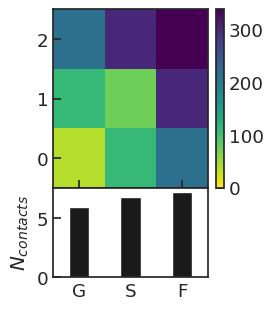

In [79]:
fig = plt.figure(figsize=(3.75,4))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,0.5])
ax0 = plt.subplot(gs[0,1])

im = ax0.imshow(n_contacts, cmap='viridis_r', \
                    vmin=0, aspect='auto', origin='lower')
divider = make_axes_locatable(ax0)
ax1 = divider.append_axes("bottom", size="50%", pad=0)
cax = divider.append_axes("right", size="5%", pad=0.08)
cb = plt.colorbar( im, ax=ax0, cax=cax )

ax1.set_xlim(-0.5, 2.5); 
ax1.set_xticks(range(3)); ax0.set_yticks(range(3))
ax1.set_xticklabels(['G', 'S', 'F'])
    
ax1.bar(range(3), n_contacts_norm, color='k', width=0.4) 
ax1.set_ylabel('$N_{contacts}$')
plt.tight_layout()
plt.savefig("figures/contacts_gsf_revision.png", dpi=300, transparent=True)

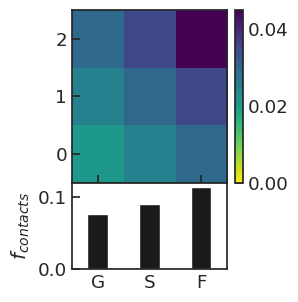

In [81]:
fig = plt.figure(figsize=(4,3.9))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,0.5])
ax0 = plt.subplot(gs[0,1])

im = ax0.imshow(f_contacts, cmap='viridis_r', \
                    vmin=0, vmax=0.045, aspect='auto', origin='lower')
divider = make_axes_locatable(ax0)
ax1 = divider.append_axes("bottom", size="50%", pad=0)
cax = divider.append_axes("right", size="5%", pad=0.08)
cb = plt.colorbar( im, ax=ax0, cax=cax )

ax1.set_xlim(-0.5, 2.5); 
ax1.set_xticks(range(3)); ax0.set_yticks(range(3))
ax1.set_xticklabels(['G', 'S', 'F'])
    
ax1.bar(range(3), f_contacts_norm, color='k', width=0.4) 
ax1.set_ylabel('$f_{contacts}$')
plt.tight_layout()
plt.savefig("figures/contacts_gsf_norm_revision.png", dpi=300)

## $\pi$-stacking

In [36]:
# Get indexes for the first three atoms in the ring
CG = [x.index for x in list(traj.topology.atoms) \
       if (x.name=='CG' and x.residue.name =='PHE')]
CD1 = [x.index for x in list(traj.topology.atoms) \
       if (x.name=='CD1' and x.residue.name =='PHE')]
CD2 = [x.index for x in list(traj.topology.atoms) \
       if (x.name=='CD2' and x.residue.name =='PHE')]

In [37]:
# Get vectors normal to the plane
normal = []
for i,j,k in list(zip(CG,CD1,CD2)):
    # calculate bond vectors
    displacements = md.compute_displacements(traj, [[i,j], [i,k]])
    # calculate normal vectors
    normal.append(unit_normal_vector(displacements[:,0,:], displacements[:,1,:]))

In [38]:
#  Get angle between vectors
angle_between_planes = []
for i,j in itertools.combinations(range(len(PHE)),2):
    angle_between_planes.append(np.arccos((normal[i]*normal[j]).sum(1)))

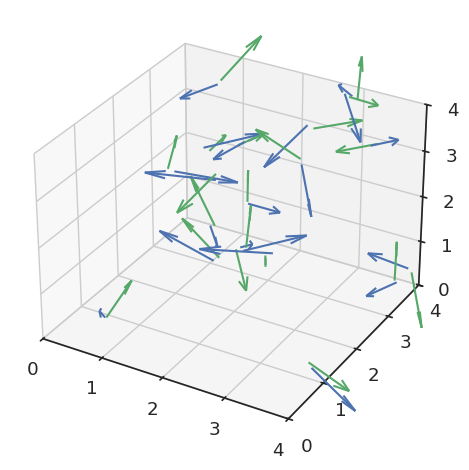

In [39]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(20):
    plt.quiver(traj.xyz[:,PHE[0]][i,0], traj.xyz[:,PHE[0]][i,1], traj.xyz[:,PHE[0]][i,2], \
               normal[0][i,0], normal[0][i,1], normal[0][i,2], color='b')
for i in range(20):
    plt.quiver(traj.xyz[:,PHE[1]][i,0], traj.xyz[:,PHE[1]][i,1], traj.xyz[:,PHE[1]][i,2], \
               normal[1][i,0], normal[1][i,1], normal[1][i,2], color='g')
ax.set_xlim(0,4); ax.set_ylim(0,4); ax.set_zlim(0,4)
plt.tight_layout()

In [40]:
ring_dist = []
for i,j in itertools.combinations(PHE,2):
    #print (list(traj.topology.residue(i).atoms))
    i_index =  [x.index for x in traj.topology.residue(i).atoms if
           x.name in ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']] 
    j_index =  [x.index for x in traj.topology.residue(j).atoms if
           x.name in ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']]
    ring_dist.append(np.mean(md.compute_distances(traj, list(itertools.product(i_index, j_index))), axis=1))

In [41]:
sel = np.array(ring_dist) < 0.65

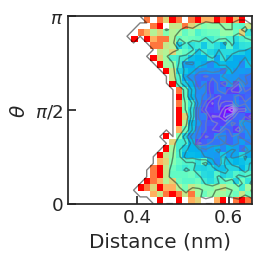

In [42]:
fig, ax = plt.subplots(figsize=(2.85, 2.85))
nbins=30
counts, xbins, ybins, image = ax.hist2d(np.array(ring_dist)[sel], np.array(angle_between_planes)[sel], \
                                        bins=(np.linspace(0.25,0.65,nbins), np.linspace(0,np.pi,nbins)), \
                                        norm=LogNorm(), cmap='rainbow_r')
ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
           linewidths=1, cmap='binary_r', alpha=0.5)

ax.set_yticks(np.linspace(0,np.pi,3)); ax.set_yticklabels([0, r"$\pi/2$", r"$\pi$"])        
ax.set_xlabel('Distance (nm)')
ax.set_ylabel(r'$\theta$')
plt.tight_layout()
#plt.savefig("figures/gsf_pipi_dist_revision.png", dpi=300, transparent=True)

In [43]:
stacked = []
for i,pair in enumerate(list(itertools.combinations(PHE,2))):
    sel = np.logical_and(ring_dist[i] < 0.45, \
                        np.abs(angle_between_planes[i] - np.pi/2) > 1)
    if np.any(sel):
       atom_select = list([atom.index for atom in traj.top.residue(pair[0]).atoms]) + \
           list([atom.index for atom in traj.top.residue(pair[1]).atoms])
  #     #print (atom_select)
       stacked.append(traj[sel].atom_slice(atom_select))
stacked_all = md.join(stacked)
stacked_all.center_coordinates()
#stacked_all.save("gsf_pistacked.gro")

<mdtraj.Trajectory with 46 frames, 40 atoms, 2 residues, and unitcells at 0x74d5c229f110>

In [44]:
stacked = []
for i,pair in enumerate(list(itertools.combinations(PHE,2))):
    sel = np.logical_and(ring_dist[i] < 0.6, \
                        np.abs(angle_between_planes[i] - np.pi/2) < 0.5)
    if np.any(sel):
       atom_select = list([atom.index for atom in traj.top.residue(pair[0]).atoms]) + \
           list([atom.index for atom in traj.top.residue(pair[1]).atoms])
  #     #print (atom_select)
       stacked.append(traj[sel].atom_slice(atom_select))
stacked_all = md.join(stacked)
stacked_all.center_coordinates()
#stacked_all.save("gsf_planar.gro")

KeyboardInterrupt: 

### sp<sub>2</sub>-$\pi$


In [45]:
table, bonds = traj.topology.to_dataframe()
print (table.head())

   serial name element  resSeq resName  chainID segmentID
0       1  CH3       C       1     ACE        0          
1       2   H1       H       1     ACE        0          
2       3   H2       H       1     ACE        0          
3       4   H3       H       1     ACE        0          
4       5    C       C       1     ACE        0          


In [46]:
# Find atoms from carboxyl groups in peptide bonds
C = [x.index for x in list(traj.topology.atoms) \
       if (x.name=='C' and x.residue.name in ['GLY', 'SER', 'PHE'])]
O = [x.index for x in list(traj.topology.atoms) \
       if (x.name=='O' and x.residue.name in ['GLY', 'SER', 'PHE'])]
N = [traj.topology.atom(i+1).index for i in O]
    #[x.index for x in list(traj.topology.atoms) \
#       if (x.name=='CA' and x.residue.name in ['GLY', 'SER', 'TYR'])]

back = list(zip(C,O,N))
n_back = len(back)

In [47]:
bb_ring_dist = []
for i,j in itertools.product(range(n_back), range(nres[2])):
    i_index = back[i]
    j_index =  [x.index for x in traj.topology.residue(PHE[j]).atoms if
           x.name in ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']]
    bb_ring_dist.append(np.median(md.compute_distances(traj, list(itertools.product(i_index, j_index))), axis=1))
len(bb_ring_dist)

29618

In [48]:
# Get vectors normal to the bond plane
bond = []
for i,j,k in back:
    # calculate bond vectors
    displacements = md.compute_displacements(traj, [[i,j], [i,k]])
    # calculate normal vectors
    bond.append(unit_normal_vector(displacements[:,0,:], displacements[:,1,:]))
    
#  Get angle between vectors
angle_bond_ring = []
for i,j in itertools.product(range(n_back), range(nres[2])):
    angle_bond_ring.append(np.arccos((bond[i]*normal[j]).sum(1)))

In [49]:
sel = np.array(bb_ring_dist) < 0.65
np.shape(bb_ring_dist), np.shape(np.array(angle_bond_ring))

((29618, 101), (29618, 101))

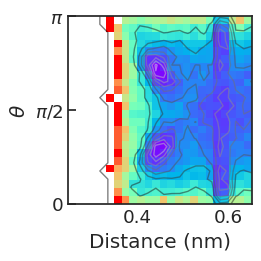

In [50]:
fig, ax = plt.subplots(figsize=(2.85, 2.85))
nbins=25
counts, xbins, ybins, image = ax.hist2d(np.array(bb_ring_dist)[sel], np.array(angle_bond_ring)[sel], \
                                        bins=(np.linspace(0.25,0.65,nbins), np.linspace(0,np.pi,nbins)), \
                                        norm=LogNorm(), cmap='rainbow_r')
ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
           linewidths=1, cmap='binary_r', alpha=0.5)
ax.set_yticks(np.linspace(0,np.pi,3)); ax.set_yticklabels([0, r"$\pi/2$", r"$\pi$"])        
ax.set_xlabel('Distance (nm)')
ax.set_ylabel(r'$\theta$')
plt.tight_layout()
#plt.savefig("figures/gsf_sp2pi_dist_revision.png", dpi=300, transparent=True)



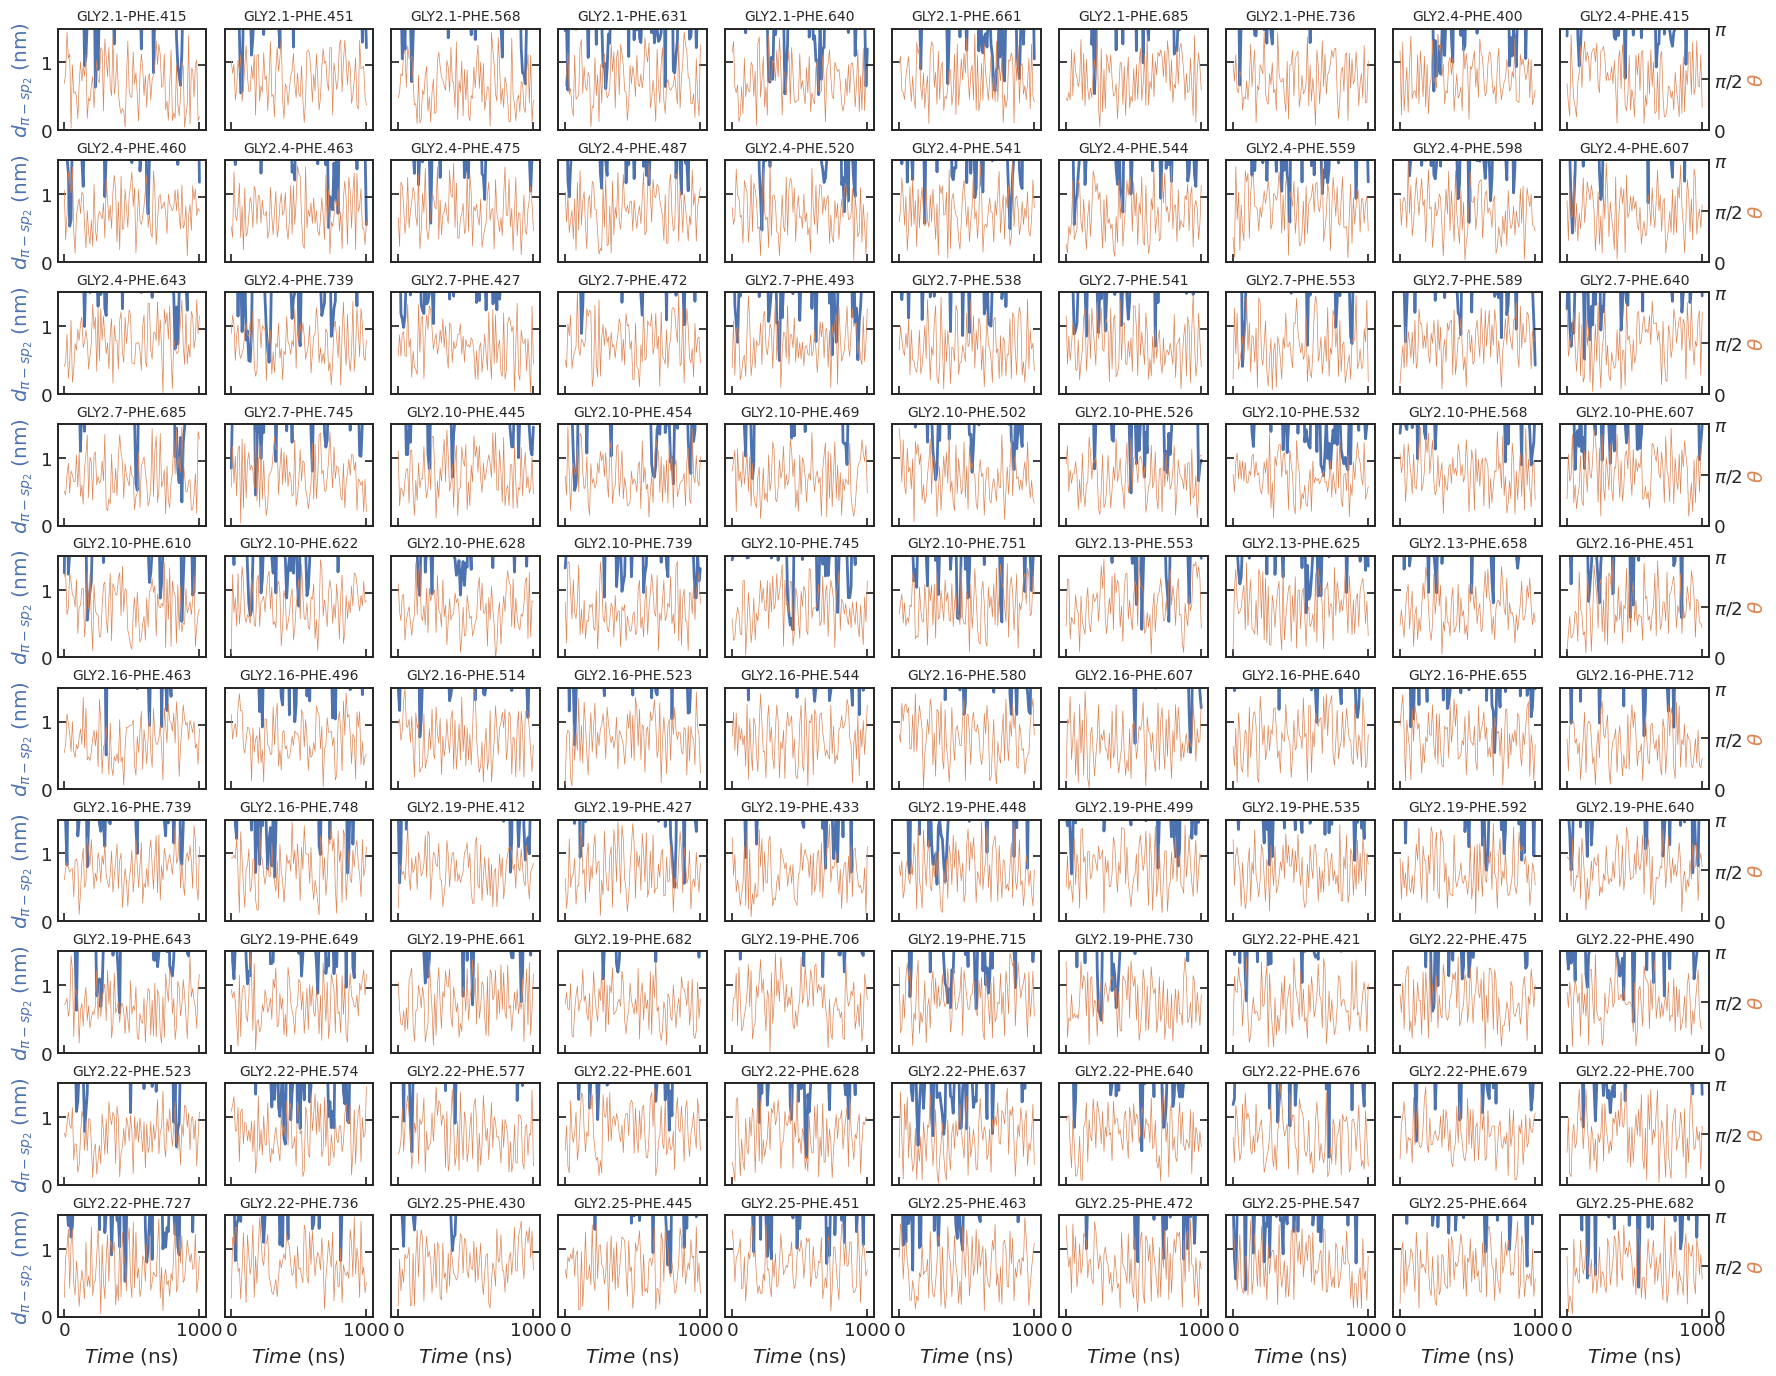

In [51]:
combinations = list(itertools.product(range(n_back), range(nres[2])))
count = 0

sel = np.array(bb_ring_dist) < 0.45

fig, ax = plt.subplots(10,10,figsize=(18,14), sharex=True, sharey=True)
ax = ax.flatten()
for i,s in enumerate(sel[100:,:]):
    if np.any(s):
        k,l = combinations[i]
        label = "%s.%i-PHE.%i"%(str(traj.topology.atom(back[k][0]).residue),traj.topology.atom(back[k][0]).residue.index, PHE[l])

        ax[count].plot(traj.time*1e-3, bb_ring_dist[i], lw=2)

        axt = ax[count].twinx()
        axt.plot(traj.time*1e-3, angle_bond_ring[i], c='C1', lw=0.5)
        axt.set_ylim(0, np.pi)
        ax[count].set_title(label, fontsize=10)

        count +=1
        if (count)%10 == 0:
            axt.set_yticks(np.linspace(0,np.pi,3)); axt.set_yticklabels([0, r"$\pi/2$", r"$\pi$"])
            axt.set_ylabel(r'$\theta$', color='C1')
        else:
            axt.set_yticklabels([])

        if count == 100:
            break    


[ax[i*10].set_ylabel(r'$d_{\pi-sp_2}$ (nm)', color='C0') for i in range(10)]
[ax[-i-1].set_xlabel(r'$Time$ (ns)') for i in range(10)]
ax[-1].set_ylim(0,1.5)
plt.tight_layout(w_pad=0, h_pad=0)

In [52]:
stacked = []
sel = (np.array(bb_ring_dist) < 0.45) & (np.array(angle_bond_ring) < 4*np.pi/5) & (np.array(angle_bond_ring) > 3*np.pi/5)
for i,s in enumerate(sel): 
    if np.any(s):
        k,l = combinations[i]
        selsel = list(back[k]) + list([x.index for x in traj.topology.residue(PHE[l]).atoms])
        try:
            stacked.append(traj[s].atom_slice(selsel))
        except ValueError as e:
            print (e)
            print (k, back[k])
            print (l, list([x.index for x in traj.topology.residue(PHE[l]).atoms]))  
            label = "%s.%i-PHE.%i"%(str(traj.topology.atom(back[k][0]).residue),traj.topology.atom(back[k][0]).residue.index, PHE[l])
            print (label)
            print ()

ie = i

sel = (np.array(bb_ring_dist) < 0.45) & (np.array(angle_bond_ring) < 2*np.pi/5) & (np.array(angle_bond_ring) > 1*np.pi/5)
for i,s in enumerate(sel): 
    if np.any(s):
        k,l = combinations[i]
        selsel = list(back[k]) + list([x.index for x in traj.topology.residue(PHE[l]).atoms])
        try:
            stacked.append(traj[s].atom_slice(selsel))
        except ValueError as e:
            print (e)
            print (k, back[k])
            print (l, list([x.index for x in traj.topology.residue(PHE[l]).atoms]))          
            label = "%s.%i-PHE.%i"%(str(traj.topology.atom(back[k][0]).residue),traj.topology.atom(back[k][0]).residue.index, PHE[l])
            print (label)

        try:
            stacked_all = md.join(stacked, check_topology=False)
            #stacked_all.save("stacked%i.gro"%(i+ie))
        except TypeError as e:
            print (e)

try:
    stacked_all = md.join(stacked, check_topology=False)
    stacked_all.superpose(reference=stacked[0])
    stacked_all.save("gsf_sp2pi_stacked.gro")

except TypeError as e:
    print (e)
    print()

/home/david/anaconda3/lib/python3.12/site-packages/mdtraj/core/topology.py:84: UserWarning: atom_indices are not monotonically increasing
  warnings.warn("atom_indices are not monotonically increasing")
/home/david/anaconda3/lib/python3.12/site-packages/mdtraj/core/topology.py:86: UserWarning: atom_indices are not unique
  warnings.warn("atom_indices are not unique")


xyz must be shape (Any, 21, 3). You supplied  (14, 23, 3)
133 (2440, 2441, 2442)
0 [2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441]
PHE2.400-PHE.400

xyz must be shape (Any, 21, 3). You supplied  (17, 23, 3)
134 (2469, 2470, 2471)
1 [2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470]
PHE2.403-PHE.403

xyz must be shape (Any, 21, 3). You supplied  (17, 23, 3)
135 (2498, 2499, 2500)
2 [2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499]
PHE2.406-PHE.406

xyz must be shape (Any, 21, 3). You supplied  (7, 23, 3)
136 (2527, 2528, 2529)
3 [2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528]
PHE2.409-PHE.409

xyz must be shape (Any, 21, 3). You supplied  (15, 23, 3)
137 (2556, 2557, 2558)
4 [2538, 2539, 2540, 2541, 2542,

## GSY multi

Processing replica 0
Filename : ../data/soup_XXL_amber99sb-star-ildnTRUE_tip3p_dense_rep0_npt_proc.xtc
Total simulation time: 496000 ps
Total number of frames: 249 

Processing replica 1
Filename : ../data/soup_XXL_amber99sb-star-ildnTRUE_tip3p_dense_rep1_npt_proc.xtc
Total simulation time: 612000 ps
Total number of frames: 307 

Processing replica 4
Filename : ../data/soup_XXL_amber99sb-star-ildnTRUE_tip3p_dense_rep4_npt_proc.xtc
Total simulation time: 500000 ps
Total number of frames: 251 

Processing replica 5
Filename : ../data/soup_XXL_amber99sb-star-ildnTRUE_tip3p_dense_rep5_npt_proc.xtc
Total simulation time: 500000 ps
Total number of frames: 251 



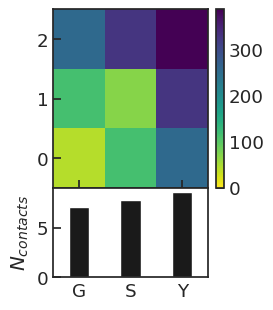

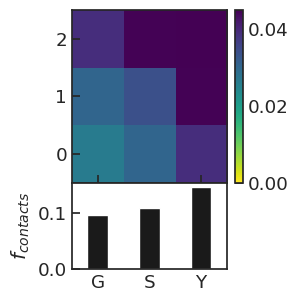

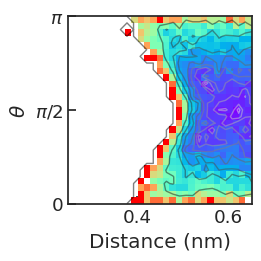

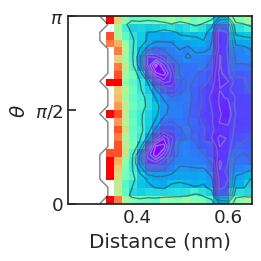

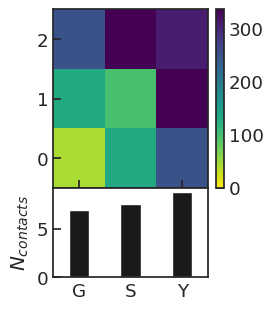

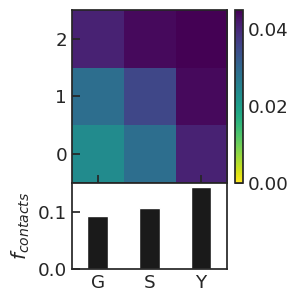

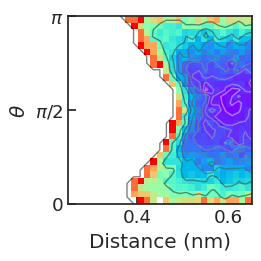

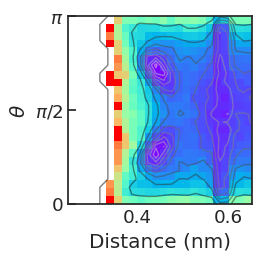

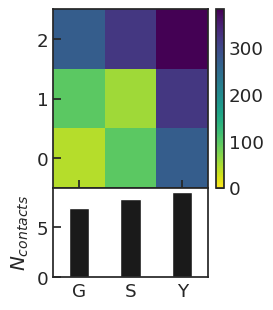

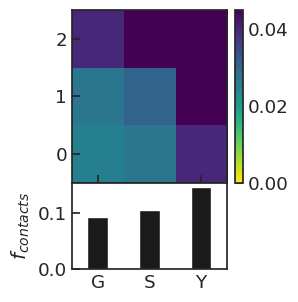

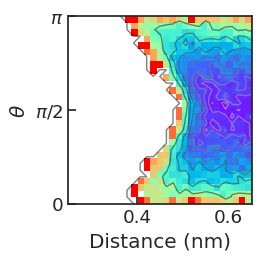

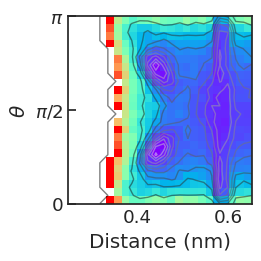

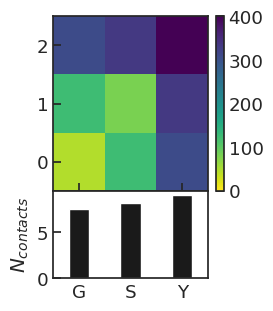

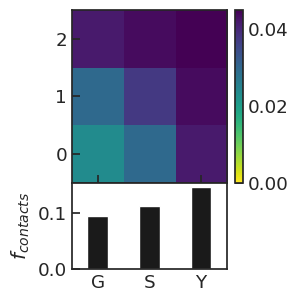

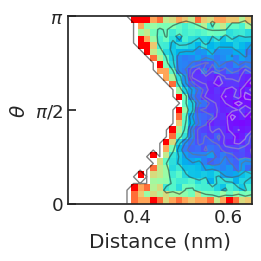

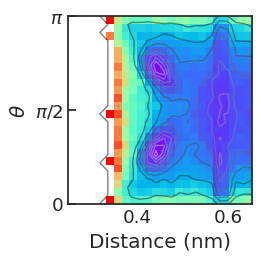

In [30]:

ring_dist_cum = []; angle_between_planes_cum = []
bb_ring_dist_cum = []; angle_bond_ring_cum = []
n_contacts_cum = []; n_contacts_norm_cum = []
f_contacts_cum = []; f_contacts_norm_cum = []

for rep in [0, 1, 4, 5]:
    xtc = "../data/soup_XXL_amber99sb-star-ildnTRUE_tip3p_dense_rep%i_npt_proc.xtc"%rep
    gro = "../data/soup_XXL_amber99sb-star-ildnTRUE_tip3p_dense_rep%i_npt_berendsen.gro"%rep
    
    traj = md.load_xtc(xtc, top=gro, stride=20)
    print ("Processing replica %i"%rep)
    print ("Filename : %s"%xtc)
    print ("Total simulation time: %i ps"%traj.time[-1])
    print ("Total number of frames: %i \n"%traj.n_frames)

    GLY = [x.index for x in list(traj.topology.residues) \
           if (x.name=='GLY')] 
    SER = [x.index for x in list(traj.topology.residues) \
           if (x.name=='SER')] 
    TYR = [x.index for x in list(traj.topology.residues) \
           if (x.name=='TYR')]

    nres = np.array([len(GLY), len(SER), len(TYR)])

    ib = 100
    # Find contacts for residue pairs 
    # 0: Gly; 1: Ser; 2: Tyr
    contact_map = {}
    contact_map[0] = {}; contact_map[1] = {}; contact_map[2] = {}
    
    contact_map[0][0] = md.compute_contacts(traj[ib:], \
                        contacts=list(itertools.combinations(GLY, 2)))    
    contact_map[1][1] = md.compute_contacts(traj[ib:], \
                        contacts=list(itertools.combinations(SER, 2)))
    contact_map[2][2] = md.compute_contacts(traj[ib:], \
                        contacts=list(itertools.combinations(TYR, 2)))
        
    contact_map[0][1] = md.compute_contacts(traj[ib:], \
                        contacts=list(itertools.product(GLY, SER)))
    contact_map[0][2] = md.compute_contacts(traj[ib:], \
                        contacts=list(itertools.product(GLY, TYR)))
    contact_map[1][2] = md.compute_contacts(traj[ib:], \
                        contacts=list(itertools.product(SER, TYR)))
    
    rcut = 0.6

    # Calculate number contacts for residue pairs 
    n_cont = np.zeros((3,3), dtype=np.int64)
    for k in contact_map.keys():
        for l in contact_map[k].keys():
                for m, (i,j) in enumerate(contact_map[k][l][1]):   
                    n_cont[k,l] += sum(contact_map[k][l][0][:,m] < rcut)
                if (l != k):
                    n_cont[l,k] = n_cont[k,l]
    lsim = len(traj[ib:]) # normalize by simulation length
    n_contacts = np.int64(n_cont/lsim)
    n_contacts_cum.append(n_contacts)

    # Calculate normalized number contacts for residue pairs 
    n_contacts_norm = np.sum(n_cont, axis=0)/nres/lsim
    n_contacts_norm_cum.append(n_contacts_norm)

    # Calculate fraction of contacts for residue pairs
    # Divides number of contacts by number of pairs for each specific type
    f_contacts = np.zeros((3,3), dtype=np.float64)
    for k in contact_map.keys():
        for l in contact_map[k].keys():
            f_contacts[k,l] = n_cont[k,l]/(len(contact_map[k][l][1]))
            if (l != k):
                f_contacts[l,k] = f_contacts[k,l]
    f_contacts = f_contacts/lsim
    f_contacts_norm = np.sum(f_contacts, axis=0, dtype=np.float64)
    f_contacts_cum.append(f_contacts)
    f_contacts_norm_cum.append(f_contacts_norm)

    fig = plt.figure(figsize=(3.75,4))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,0.5])
    ax0 = plt.subplot(gs[0,1])

    im = ax0.imshow(n_contacts, cmap='viridis_r', \
                        vmin=0, aspect='auto', origin='lower')
    divider = make_axes_locatable(ax0)
    ax1 = divider.append_axes("bottom", size="50%", pad=0)
    cax = divider.append_axes("right", size="5%", pad=0.08)
    cb = plt.colorbar( im, ax=ax0, cax=cax )

    ax1.set_xlim(-0.5, 2.5); 
    ax1.set_xticks(range(3)); ax0.set_yticks(range(3))
    ax1.set_xticklabels(['G', 'S', 'Y'])

    ax1.bar(range(3), n_contacts_norm, color='k', width=0.4) 
    ax1.set_ylabel('$N_{contacts}$')
    plt.tight_layout()

    fig = plt.figure(figsize=(4,3.9))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,0.5])
    ax0 = plt.subplot(gs[0,1])

    im = ax0.imshow(f_contacts, cmap='viridis_r', \
                    vmin=0, vmax=0.045, aspect='auto', origin='lower')
    divider = make_axes_locatable(ax0)
    ax1 = divider.append_axes("bottom", size="50%", pad=0)
    cax = divider.append_axes("right", size="5%", pad=0.08)
    cb = plt.colorbar( im, ax=ax0, cax=cax )

    ax1.set_xlim(-0.5, 2.5); 
    ax1.set_xticks(range(3)); ax0.set_yticks(range(3))
    ax1.set_xticklabels(['G', 'S', 'Y'])
    
    ax1.bar(range(3), f_contacts_norm, color='k', width=0.4) 
    ax1.set_ylabel('$f_{contacts}$')
    plt.tight_layout()
    #plt.savefig("figures/contacts_gsy.png", dpi=300, transparent=True)
    
    ring_dist = []
    for i,j in itertools.combinations(TYR,2):
         #print (list(traj.topology.residue(i).atoms))
         i_index =  [x.index for x in traj.topology.residue(i).atoms if
                     x.name in ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']] 
         j_index =  [x.index for x in traj.topology.residue(j).atoms if
                     x.name in ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']]
         ring_dist.append(np.mean(md.compute_distances(traj, list(itertools.product(i_index, j_index))), axis=1))

    # Get indexes for the first three atoms in the ring
    CG = [x.index for x in list(traj.topology.atoms) \
           if (x.name=='CG' and x.residue.name =='TYR')]
    CD1 = [x.index for x in list(traj.topology.atoms) \
           if (x.name=='CD1' and x.residue.name =='TYR')]
    CD2 = [x.index for x in list(traj.topology.atoms) \
           if (x.name=='CD2' and x.residue.name =='TYR')]

    # Get vectors normal to the plane
    normal = []
    for i,j,k in list(zip(CG,CD1,CD2)):
        # calculate bond vectors
        displacements = md.compute_displacements(traj, [[i,j], [i,k]])

        # calculate normal vectors
        normal.append(unit_normal_vector(displacements[:,0,:], displacements[:,1,:]))

    #  Get angle between vectors
    angle_between_planes = []
    for i,j in itertools.combinations(range(len(TYR)),2):
        angle_between_planes.append(np.arccos((normal[i]*normal[j]).sum(1)))
    stacked = []
    for i, pair in enumerate(list(itertools.combinations(TYR,2))):
        sel = np.logical_and(ring_dist[i] < 0.45,  \
                    np.abs(angle_between_planes[i] - np.pi/2) > 1)
        if np.any(sel):
              atom_select = list([atom.index for atom in traj.top.residue(pair[0]).atoms]) + \
                list([atom.index for atom in traj.top.residue(pair[1]).atoms])
              stacked.append(traj[sel].atom_slice(atom_select))
    stacked_all = md.join(stacked)
    stacked_all.center_coordinates()
    #stacked_all.save("gsy_pistacked_rep%i.gro"%rep)

    sel = np.array(ring_dist) < 0.65
    fig, ax = plt.subplots(figsize=(2.85, 2.85))
    nbins=30
    counts, xbins, ybins, image = ax.hist2d(np.array(ring_dist)[sel], np.array(angle_between_planes)[sel], \
                                            bins=(np.linspace(0.25, 0.65, nbins), np.linspace(0, np.pi, nbins)), \
                                            norm=LogNorm(), cmap='rainbow_r')
    ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
               linewidths=1, cmap='binary_r', alpha=0.5)
    ring_dist_cum.append(np.array(ring_dist)[sel]); angle_between_planes_cum.append(np.array(angle_between_planes)[sel])

    ax.set_yticks(np.linspace(0,np.pi,3)); ax.set_yticklabels([0, r"$\pi/2$", r"$\pi$"])        
    ax.set_xlabel('Distance (nm)')
    ax.set_ylabel(r'$\theta$')
    plt.tight_layout()
    #plt.savefig("figures/gsy_pipi_dist.png", dpi=300, transparent=True)

    # Find atoms from carboxyl groups in peptide bonds
    C = [x.index for x in list(traj.topology.atoms) \
        if (x.name=='C' and x.residue.name in ['GLY', 'SER', 'TYR'])]
    O = [x.index for x in list(traj.topology.atoms) \
           if (x.name=='O' and x.residue.name in ['GLY', 'SER', 'TYR'])]
    N = [traj.topology.atom(i+1).index for i in O]
        #[x.index for x in list(traj.topology.atoms) \
#       if (x.name=='CA' and x.residue.name in ['GLY', 'SER', 'TYR'])]

    back = list(zip(C,O,N))
    n_back = len(back)

    bb_ring_dist = []
    for i,j in itertools.product(range(n_back), range(nres[2])):
        i_index = back[i]
        j_index =  [x.index for x in traj.topology.residue(TYR[j]).atoms if
            x.name in ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']]
        bb_ring_dist.append(np.median(md.compute_distances(traj, list(itertools.product(i_index, j_index))), axis=1))

    # Get vectors normal to the bond plane
    bond = []
    for i,j,k in back:
        # calculate bond vectors
        displacements = md.compute_displacements(traj, [[i,j], [i,k]])
        # calculate normal vectors
        bond.append(unit_normal_vector(displacements[:,0,:], displacements[:,1,:]))

    #  Get angle between vectors
    angle_bond_ring = []
    for i,j in itertools.product(range(n_back), range(nres[2])):
        angle_bond_ring.append(np.arccos((bond[i]*normal[j]).sum(1)))
    sel = np.array(bb_ring_dist) < 0.65

    fig, ax = plt.subplots(figsize=(2.85, 2.85))
    nbins=25
    counts, xbins, ybins, image = ax.hist2d(np.array(bb_ring_dist)[sel], np.array(angle_bond_ring)[sel], \
                                            bins=(np.linspace(0.25,0.65,nbins), np.linspace(0,np.pi,nbins)), \
                                            norm=LogNorm(), cmap='rainbow_r')
    ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
               linewidths=1, cmap='binary_r', alpha=0.5)
    #print (np.array(bb_ring_dist)[sel])

    bb_ring_dist_cum.append(np.array(bb_ring_dist)[sel]); angle_bond_ring_cum.append(np.array(angle_bond_ring)[sel])

#    combinations = list(itertools.product(range(n_back), range(nres[2])))
#
#    stacked = []
#    sel = (np.array(bb_ring_dist) < 0.45) & (np.array(angle_bond_ring) < 4*np.pi/5) & (np.array(angle_bond_ring) > 3*np.pi/5)
#    for i,s in enumerate(sel): 
#        if np.any(s):
#            k,l = combinations[i]
#            selsel = list(back[k]) + list([x.index for x in traj.topology.residue(TYR[l]).atoms])
#            try:
#                stacked.append(traj[s].atom_slice(selsel))
#            except ValueError as e:
#                print (e)
#                print (k, back[k])
#                print (l, list([x.index for x in traj.topology.residue(TYR[l]).atoms]))  
#                label = "%s.%i-TYR.%i"%(str(traj.topology.atom(back[k][0]).residue),traj.topology.atom(back[k][0]).residue.index, TYR[l])
#                print (label)
#                print ()
#
#    ie = i
#    sel = (np.array(bb_ring_dist) < 0.45) & (np.array(angle_bond_ring) < 2*np.pi/5) & (np.array(angle_bond_ring) > 1*np.pi/5)
#    for i,s in enumerate(sel): 
#        if np.any(s):
#            k,l = combinations[i]
#            selsel = list(back[k]) + list([x.index for x in traj.topology.residue(TYR[l]).atoms])
#            try:
#                stacked.append(traj[s].atom_slice(selsel))
#            except ValueError as e:
#                print (e)
#                print (k, back[k])
#                print (l, list([x.index for x in traj.topology.residue(TYR[l]).atoms]))          
#                label = "%s.%i-TYR.%i"%(str(traj.topology.atom(back[k][0]).residue),traj.topology.atom(back[k][0]).residue.index, TYR[l])
#                print (label)
#
#    try:
#        stacked_all = md.join(stacked, check_topology=False)
#        stacked_all.superpose(reference=stacked[0])
#        stacked_all.save("gsy_sp2pi_stacked_rep%i.gro"%rep)
#
#    except TypeError as e:
#        print (e)
#        print()
    #ax.axhline(3*np.pi/5, ls='--', color='k')
    #ax.axhline(4*np.pi/5, ls='--', color='k')
    ax.set_xlabel('Distance (nm)')
    ax.set_ylabel(r'$\theta$')
    ax.set_yticks(np.linspace(0,np.pi,3)); ax.set_yticklabels([0, r"$\pi/2$", r"$\pi$"])        
    plt.tight_layout()
    #plt.savefig("figures/gsy_sp2pi_dist.png", dpi=300, transparent=True)

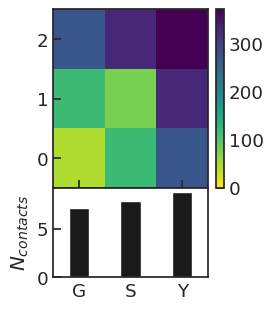

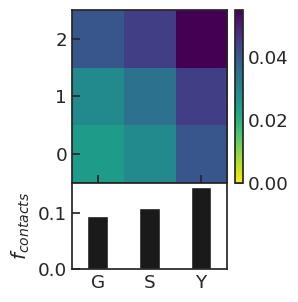

In [31]:
fig = plt.figure(figsize=(3.75,4))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,0.5])
ax0 = plt.subplot(gs[0,1])

im = ax0.imshow(np.mean(n_contacts_cum, axis=0), cmap='viridis_r', \
                    vmin=0, aspect='auto', origin='lower')
divider = make_axes_locatable(ax0)
ax1 = divider.append_axes("bottom", size="50%", pad=0)
cax = divider.append_axes("right", size="5%", pad=0.08)
cb = plt.colorbar( im, ax=ax0, cax=cax )

ax1.set_xlim(-0.5, 2.5); 
ax1.set_xticks(range(3)); ax0.set_yticks(range(3))
ax1.set_xticklabels(['G', 'S', 'Y'])

ax1.bar(range(3), np.mean(n_contacts_norm_cum, axis=0), color='k', width=0.4) 
ax1.set_ylabel('$N_{contacts}$')
plt.tight_layout()
plt.savefig("figures/contacts_gsy_revision.png", dpi=300, transparent=True)

fig = plt.figure(figsize=(4,3.9))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,0.5])
ax0 = plt.subplot(gs[0,1])

im = ax0.imshow(np.mean(f_contacts_cum, axis=0), cmap='viridis_r', \
                vmin=0, vmax=0.055, aspect='auto', origin='lower')
divider = make_axes_locatable(ax0)
ax1 = divider.append_axes("bottom", size="50%", pad=0)
cax = divider.append_axes("right", size="5%", pad=0.08)
cb = plt.colorbar( im, ax=ax0, cax=cax )

ax1.set_xlim(-0.5, 2.5); 
ax1.set_xticks(range(3)); ax0.set_yticks(range(3))
ax1.set_xticklabels(['G', 'S', 'Y'])

ax1.bar(range(3), np.mean(f_contacts_norm_cum, axis=0), color='k', width=0.4) 
ax1.set_ylabel('$f_{contacts}$')
plt.tight_layout()
plt.savefig("figures/contacts_gsy_norm_revision.png", dpi=300, transparent=False)

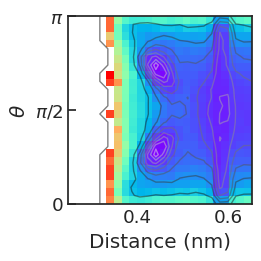

In [32]:
fig, ax = plt.subplots(figsize=(2.85, 2.85))
nbins=25
counts, xbins, ybins, image = ax.hist2d(np.concatenate(bb_ring_dist_cum), np.concatenate(angle_bond_ring_cum), \
                                        bins=(np.linspace(0.25,0.65,nbins), np.linspace(0,np.pi,nbins)), \
                                        norm=LogNorm(), cmap='rainbow_r')
ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
           linewidths=1, cmap='binary_r', alpha=0.5)

#ax.axhline(3*np.pi/5, ls='--', color='k')
#ax.axhline(4*np.pi/5, ls='--', color='k')
ax.set_xlabel('Distance (nm)')
ax.set_ylabel(r'$\theta$')
ax.set_yticks(np.linspace(0,np.pi,3)); ax.set_yticklabels([0, r"$\pi/2$", r"$\pi$"])        
plt.tight_layout()
plt.savefig("figures/gsy_sp2pi_dist_revision.png", dpi=300, transparent=True)

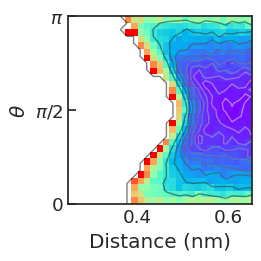

In [33]:
fig, ax = plt.subplots(figsize=(2.85, 2.85))
nbins=30
counts, xbins, ybins, image = ax.hist2d(np.concatenate(ring_dist_cum), np.concatenate(angle_between_planes_cum), \
                                        bins=(np.linspace(0.25, 0.65, nbins), np.linspace(0, np.pi, nbins)), \
                                        norm=LogNorm(), cmap='rainbow_r')
ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
           linewidths=1, cmap='binary_r', alpha=0.5)

ax.set_yticks(np.linspace(0,np.pi,3)); ax.set_yticklabels([0, r"$\pi/2$", r"$\pi$"])        
ax.set_xlabel('Distance (nm)')
ax.set_ylabel(r'$\theta$')
plt.tight_layout()
plt.savefig("figures/gsy_pipi_dist_revision.png", dpi=300, transparent=True)


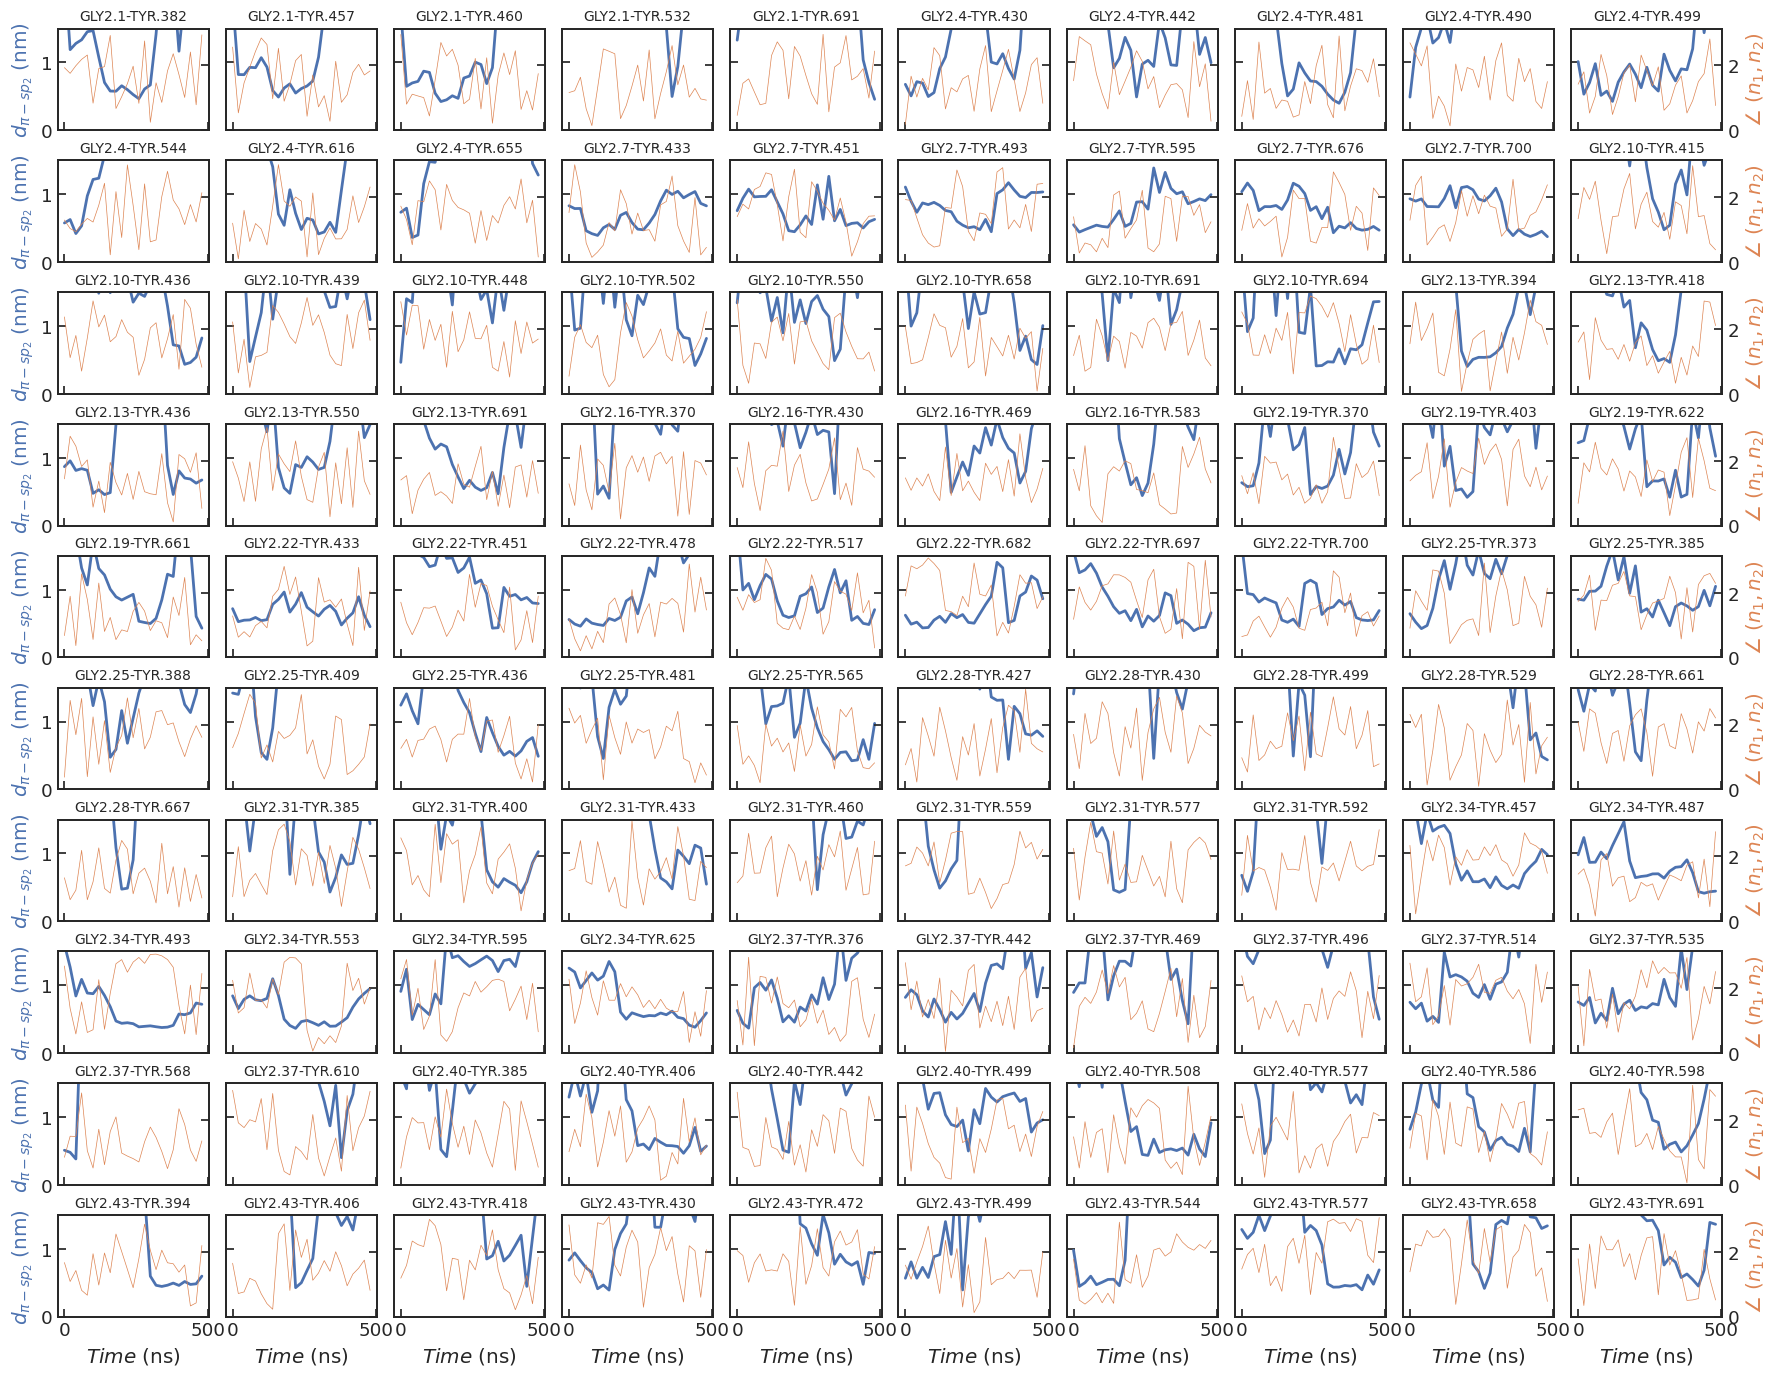

In [74]:
combinations = list(itertools.product(range(n_back), range(nres[2])))
count = 0

sel = np.array(bb_ring_dist) < 0.5

fig, ax = plt.subplots(10,10,figsize=(18,14), sharex=True, sharey=True)
ax = ax.flatten()
for i,s in enumerate(sel):
    if np.any(s):
        k,l = combinations[i]
        label = "%s.%i-TYR.%i"%(str(traj.topology.atom(back[k][0]).residue),traj.topology.atom(back[k][0]).residue.index, TYR[l])

        ax[count].plot(traj.time*1e-3, bb_ring_dist[i], lw=2)

        axt = ax[count].twinx()
        axt.plot(traj.time*1e-3, angle_bond_ring[i], c='C1', lw=0.5)
        axt.set_ylim(0, np.pi)
        ax[count].set_title(label, fontsize=10)

        count +=1
        if (count)%10 == 0:
            axt.set_ylabel(r'$\angle$ ($n_1,n_2$)', color='C1')
        else:
            axt.set_yticklabels([])

        if count == 100:
            break    


[ax[i*10].set_ylabel(r'$d_{\pi-sp_2}$ (nm)', color='C0') for i in range(10)]
[ax[-i-1].set_xlabel(r'$Time$ (ns)') for i in range(10)]
ax[-1].set_ylim(0,1.5)
plt.tight_layout(w_pad=0, h_pad=0)

In [75]:
stacked = []
sel = (np.array(bb_ring_dist) < 0.45) & (np.array(angle_bond_ring) < 4*np.pi/5) & (np.array(angle_bond_ring) > 3*np.pi/5)
for i,s in enumerate(sel): 
    if np.any(s):
        k,l = combinations[i]
        selsel = list(back[k]) + list([x.index for x in traj.topology.residue(TYR[l]).atoms])
        try:
            stacked.append(traj[s].atom_slice(selsel))
        except ValueError as e:
            print (e)
            print (k, back[k])
            print (l, list([x.index for x in traj.topology.residue(TYR[l]).atoms]))          
            label = "%s.%i-TYR.%i"%(str(traj.topology.atom(back[k][0]).residue),traj.topology.atom(back[k][0]).residue.index, TYR[l])
            print (label)
            print ()
ie = i

sel = (np.array(bb_ring_dist) < 0.45) & (np.array(angle_bond_ring) < 2*np.pi/5) & (np.array(angle_bond_ring) > 1*np.pi/5)
for i,s in enumerate(sel): 
    if np.any(s):
        k,l = combinations[i]
        selsel = list(back[k]) + list([x.index for x in traj.topology.residue(TYR[l]).atoms])
        try:
            stacked.append(traj[s].atom_slice(selsel))
        except ValueError as e:
            print (e)
            print (k, back[k])
            print (l, list([x.index for x in traj.topology.residue(TYR[l]).atoms]))          
            label = "%s.%i-TYR.%i"%(str(traj.topology.atom(back[k][0]).residue),traj.topology.atom(back[k][0]).residue.index, TYR[l])
            print (label)

        try:
            stacked_all = md.join(stacked, check_topology=False)
            stacked_all.save("stacked%i.gro"%(i+ie))
        except TypeError as e:
            print (e)

try:
    stacked_all = md.join(stacked, check_topology=False)
    stacked_all.superpose(reference=stacked[0])
    stacked_all.save("gsf_sp2pi_stacked.gro")

except TypeError as e:
    print (e)
    print()


/home/david/anaconda3/lib/python3.12/site-packages/mdtraj/core/topology.py:84: UserWarning: atom_indices are not monotonically increasing
  warnings.warn("atom_indices are not monotonically increasing")
/home/david/anaconda3/lib/python3.12/site-packages/mdtraj/core/topology.py:86: UserWarning: atom_indices are not unique
  warnings.warn("atom_indices are not unique")


xyz must be shape (Any, 22, 3). You supplied  (2, 24, 3)
124 (2283, 2284, 2285)
1 [2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284]
TYR2.373-TYR.373

xyz must be shape (Any, 22, 3). You supplied  (8, 24, 3)
126 (2343, 2344, 2345)
3 [2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344]
TYR2.379-TYR.379

xyz must be shape (Any, 22, 3). You supplied  (1, 24, 3)
127 (2373, 2374, 2375)
4 [2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374]
TYR2.382-TYR.382

xyz must be shape (Any, 22, 3). You supplied  (2, 24, 3)
128 (2403, 2404, 2405)
5 [2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404]
TYR2.385-TYR.385

xyz must be shape (Any, 22, 3). You supplied  (2, 24, 3)
129 (2433, 2434, 2435)
6 [2414, 241